In [58]:
import os 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import geopandas
import geoplot
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd

In [2]:
import os
import time
import copy

import tensorflow as tf
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = '../../data/'
IMAGES_DIR = os.path.join(DATA_DIR, 'images')
PROCESS_DIR = os.path.join(DATA_DIR, 'process')
MODEL_DIR = '../../data/model'

### **Vrais labels**

In [4]:
alep = pd.read_csv(os.path.join(PROCESS_DIR, 'data_label_alep.csv'))
alep.head(3)

,label,geometry
0,1,POINT (37.13543285100008 36.23547293500008)
1,1,POINT (37.13539414500008 36.23556617700007)
2,1,POINT (37.13908459400005 36.24100053500007)


In [5]:
from shapely import wkt

alep['Coordinates'] = alep['geometry'].apply(wkt.loads)

In [6]:
alep=alep.set_geometry('Coordinates')

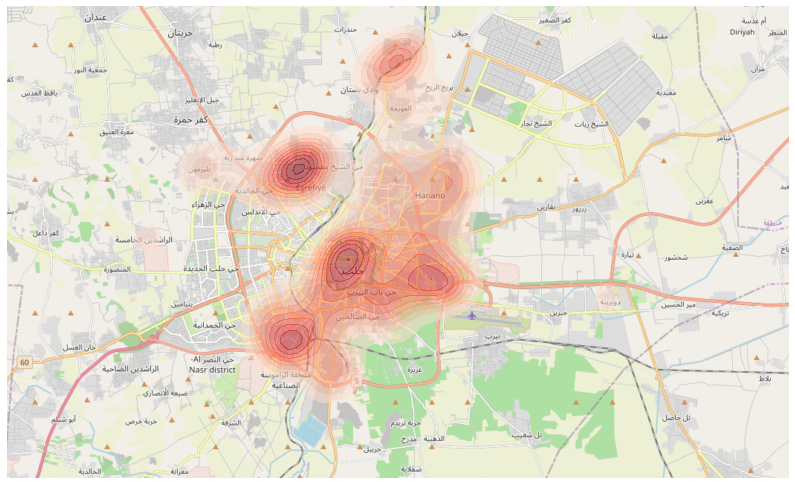

In [60]:
#ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea())
ax=gplt.webmap(alep, projection=gcrs.WebMercator(),figsize=(14,14))
ax.set_alpha(0)
gplt.kdeplot(alep[alep.label == 1], cmap='Reds', shade=True, shade_lowest=False, ax=ax, alpha=0.5)
#gplt.kdeplot(alep[alep.label==0], cmap='Blues', shade=False, shade_lowest=False,ax=ax)
plt.show()

### **Prédictions des modèles sur Alep**

In [8]:
alep_preds = pd.read_csv(os.path.join(PROCESS_DIR, 'images_label_alep.csv'))
alep_preds.head(3)

,centroide,zone,image,label,nom_images_torchvision,segment
0,POINT (37.09011936115785 36.16143367034777),"POLYGON ((37.0893785797742 36.16069289266107, ...",alep_37.09011936115785_36.16143367034777.jpg,0,alep_0000.jpg,train
1,POINT (37.09160092392516 36.16143367034777),"POLYGON ((37.09086014254151 36.16069289266107,...",alep_37.091600923925164_36.16143367034777.jpg,0,alep_0001.jpg,train
2,POINT (37.09308248669247 36.16143367034777),"POLYGON ((37.09234170530882 36.16069289266107,...",alep_37.093082486692474_36.16143367034777.jpg,0,alep_0002.jpg,train


In [9]:
alep_preds['pred_no_euroSAT'] = np.zeros(alep_preds.shape[0])
alep_preds['pred_euroSAT'] = np.zeros(alep_preds.shape[0])

In [16]:
from PIL import Image

def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

In [21]:
def get_input_transform():   
    transf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

In [22]:
def prediction_image_path(image_path, model):
    """ Sort les predictions d'un model sur l'image
        passee en arguement.
    """
    img = get_image(image_path)
    
    model = model.to(device)
    model.eval()
    
    img_t = get_input_tensors(img)
    img_t = img_t.to(device)
    
    output = model(img_t)
    _, pred = torch.max(output, 1)
    
    return pred

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('%d GPU(s) disponible.' % torch.cuda.device_count())
    print('GPU utilisé :', torch.cuda.get_device_name(0))

else:
    print('Pas de GPU disponible, utilisation du CPU.')
    device = torch.device("cpu")

1 GPU(s) disponible.
GPU utilisé : GeForce GTX 1050 Ti


In [24]:
model_euroSAT = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_euroSAT.fc.in_features
model_euroSAT.fc = nn.Linear(num_ftrs, 2)
model_euroSAT.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'all_model_euroSAT.pt')))

model_no_euroSAT = models.resnet50(pretrained=False, progress=True)
num_ftrs = model_no_euroSAT.fc.in_features
model_no_euroSAT.fc = nn.Linear(num_ftrs, 2)
model_no_euroSAT.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'all_model_no_euroSAT.pt')))

<All keys matched successfully>

In [26]:
for idx, obs in alep_preds.iterrows():
    image_nom = obs['nom_images_torchvision']
    image_path = os.path.join(IMAGES_DIR, 'alep', obs['segment'], str(obs['label']), image_nom)
    obs['pred_no_euroSAT'] = prediction_image_path(image_path, model_no_euroSAT)
    obs['pred_euroSAT'] = prediction_image_path(image_path, model_euroSAT)

In [39]:
alep_preds.to_csv(os.path.join(PROCESS_DIR, 'images_label&pred_alep.csv'), index=False)

In [30]:
alep_preds.head()
# alep_preds[alep_preds['label'] != alep_preds['pred_euroSAT']].head()

,centroide,zone,image,label,nom_images_torchvision,segment,pred_no_euroSAT,pred_euroSAT
0,POINT (37.09011936115785 36.16143367034777),"POLYGON ((37.0893785797742 36.16069289266107, ...",alep_37.09011936115785_36.16143367034777.jpg,0,alep_0000.jpg,train,0.0,0.0
1,POINT (37.09160092392516 36.16143367034777),"POLYGON ((37.09086014254151 36.16069289266107,...",alep_37.091600923925164_36.16143367034777.jpg,0,alep_0001.jpg,train,0.0,0.0
2,POINT (37.09308248669247 36.16143367034777),"POLYGON ((37.09234170530882 36.16069289266107,...",alep_37.093082486692474_36.16143367034777.jpg,0,alep_0002.jpg,train,0.0,0.0


In [33]:
alep_preds['Coordinates'] = alep_preds['centroide'].apply(wkt.loads)
alep_preds = alep_preds.set_geometry('Coordinates')

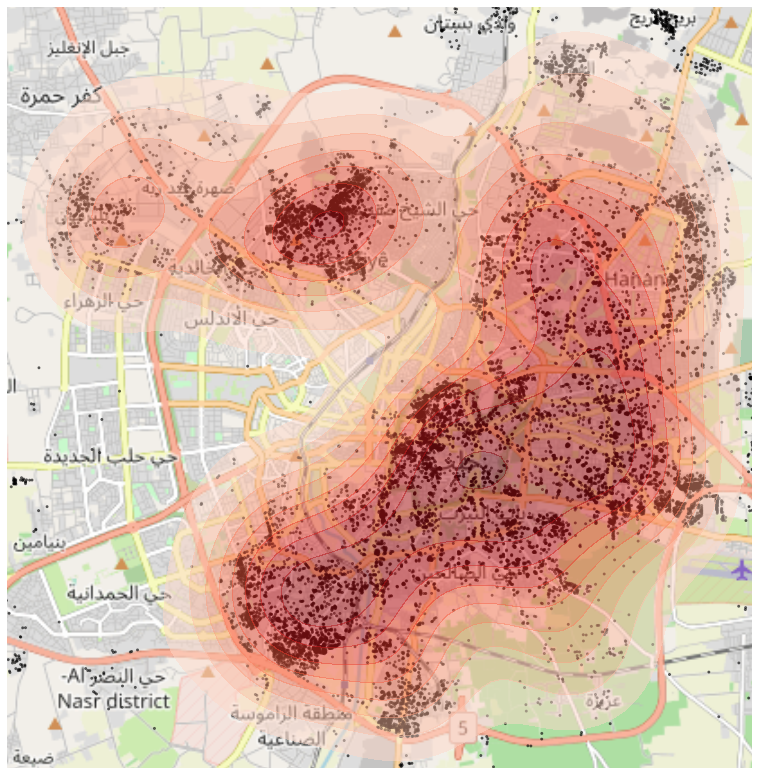

In [61]:
ax = gplt.webmap(alep, projection=gcrs.WebMercator(), figsize=(14, 14))
ax.set_alpha(0)
gplt.pointplot(alep[alep['label'] == 1], ax=ax, alpha=0.5, s=2, color='black')
gplt.kdeplot(alep_preds[alep_preds['label'] == 1], cmap='Reds', shade=True, shade_lowest=False, ax=ax, alpha=0.5)
plt.show()

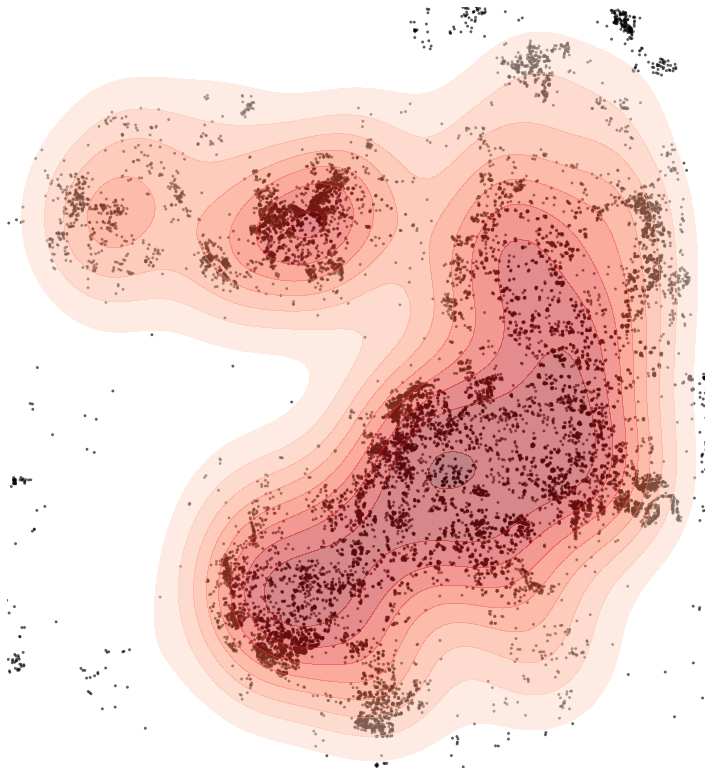

In [56]:
ax = gplt.polyplot(alep, projection=gcrs.AlbersEqualArea(), figsize=(14, 14))
ax.set_alpha(0)
gplt.pointplot(alep[alep['label'] == 1], ax=ax, alpha=0.5, s=2, color='black')
gplt.kdeplot(alep_preds[alep_preds['label'] == 1], cmap='Reds', shade=True, shade_lowest=False, ax=ax, alpha=0.5)
plt.show()

------------------------
_____________________

------------------------
_____________________

------------------------
_____________________

In [99]:
gplt.kdeplot(alep[alep.label==1], cmap='Reds', shade=True, shade_lowest=False,ax=m,alpha=0.5)

AttributeError: 'Map' object has no attribute 'get_figure'

In [100]:

import contextily as ctx
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()

<Figure size 432x288 with 0 Axes>